This notebook presents an example of using the moltr package for multi-objective learning to rank. It consists of two sections. 

In the first section, we compare our custom objective implementation with the original one from LightGBM. Specifically, we check that it produces similar results and has a similar runtime.

In the second section, we use the custom objective to build a LambdaMART model optimising a combination of two NDCG-type metrics.

In [1]:
import warnings


warnings.simplefilter("ignore")

In [2]:
import numpy as np
import pandas as pd

import lightgbm as lgb

from matplotlib import pyplot as plt

In [3]:
from moltr.lambdaobj import get_gradients
from moltr.calculator import Calculator, MIN_SIGMOID_ARG, MAX_SIGMOID_ARG

### Generating Data

In [4]:
np.random.seed(0)

In [5]:
def generate_data(n_positions, coef, n_requests):
    """
    This function is used for simulating the data. We generate n_requests result pages
    with n_positions positions each. We simulate interactions of two types. A logistic 
    regression model is used for generating interactions of each type. The coefficients
    are provided via the coef parameter. This parameter must be a matrix with
    two rows. The number of features is inferred from the number of its columns.
    Features are simulated as standard normal random variables.
    :param page_len: the number of positions on each result page
    :param coef: a matrix defining the two logistic regression models for generating
                 interactions
    :param n_requests: the number of requests/queries/result pages
    :returns: a pandas.DataFrame having n_requests * n_positions rows 
              and the following columns:
                request_id,
                feature_1, ..., feature_m (where m is coef.shape[1]),
                i_1 and i2 (interaction indicators - one for each interaction type)
    """
    n_features = coef.shape[1]
    feature_names = ["feature_%i" % i for i in range(1, n_features + 1)]
    data = pd.DataFrame(
        np.concatenate(
            [
                np.repeat(range(n_requests), n_positions)[:, None],
                np.random.normal(0, 1, (n_requests * n_positions, n_features))
            ],
            axis=1
        ),
        columns=["request_id"] + feature_names
    )
    for i in range(2):
        z = np.dot(data[feature_names].values, coef[i, :]) - 4.0
        data[f"i_{i + 1}"] = np.random.binomial(1, 1 / (1 + np.exp(-z)))
    
    return data


def drop_requests_with_no_interactions(data, interaction_col):
    interaction_requests = set(data.loc[data[interaction_col] > 0].request_id)
    return data.loc[data.request_id.isin(interaction_requests)]

In [6]:
COEF = np.array(
    [
        [1.0, -1.0, 1.0],
        [-1.0, 1.0, 1.0]
    ]
)
N_POSITIONS = 32
MAX_NDCG_POS = 10
N_TRAIN = 10000
N_VALIDATION = 1000

In [7]:
train_data = generate_data(N_POSITIONS, COEF, N_TRAIN)
validation_data = generate_data(N_POSITIONS, COEF, N_VALIDATION)

### Custom Objective Code

In [8]:
class DatasetWithCalculator(lgb.Dataset):
    def __init__(self, *args, **kwargs):
        lgb.Dataset.__init__(self, *args, **kwargs)
        self.calculator = Calculator(self.label, self.get_group(), MAX_NDCG_POS)

In [9]:
def lambdamart_objective(preds, dataset):
    groups = dataset.get_group()
    if len(groups) == 0:
        raise Error("Group/query data should not be empty.")
    else:
        grad = np.zeros(len(preds))
        hess = np.zeros(len(preds))
        get_gradients(np.ascontiguousarray(dataset.label, dtype=np.double), 
                      np.ascontiguousarray(preds),
                      len(preds),
                      np.ascontiguousarray(groups),
                      np.ascontiguousarray(dataset.calculator.query_boundaries),
                      len(dataset.calculator.query_boundaries) - 1,
                      np.ascontiguousarray(dataset.calculator.discounts),
                      np.ascontiguousarray(dataset.calculator.inverse_max_dcgs),
                      np.ascontiguousarray(dataset.calculator.sigmoids),
                      len(dataset.calculator.sigmoids),
                      MIN_SIGMOID_ARG,
                      MAX_SIGMOID_ARG,
                      dataset.calculator.sigmoid_idx_factor,
                      np.ascontiguousarray(grad), 
                      np.ascontiguousarray(hess))
        return grad, hess

## Section 1. Training with a Custom Objective

In [10]:
train_data_1 = drop_requests_with_no_interactions(train_data, "i_1")
train_dataset_1 = DatasetWithCalculator(
    train_data_1.drop(["request_id", "i_1", "i_2"], axis=1),
    label=train_data_1.i_1,
    group=[N_POSITIONS] * train_data_1.request_id.nunique(),
    free_raw_data=False
)

Computing inverse_max_dcg-s..
Computing sigmoids..


In [11]:
lgb_params = {
    "num_trees": 10,
    "objective": "lambdarank",
    "max_position": MAX_NDCG_POS, 
    "metric": "ndcg",
    "eval_at": MAX_NDCG_POS
}

In [12]:
def fit_original(dataset, verbose_eval=True):
    lgb.train(
        params=lgb_params, 
        train_set=dataset,
        valid_sets=[dataset],
        verbose_eval=verbose_eval
    )    


fit_original(train_dataset_1)

[1]	training's ndcg@10: 0.570918
[2]	training's ndcg@10: 0.600124
[3]	training's ndcg@10: 0.609498
[4]	training's ndcg@10: 0.615429
[5]	training's ndcg@10: 0.617372
[6]	training's ndcg@10: 0.620546
[7]	training's ndcg@10: 0.622058
[8]	training's ndcg@10: 0.623873
[9]	training's ndcg@10: 0.625059
[10]	training's ndcg@10: 0.626115


In [13]:
%timeit -r 100 fit_original(train_dataset_1, False)

254 ms ± 95.1 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)


In [14]:
def fit_custom_objective(dataset, verbose_eval=True):
    lgb.train(
        params=lgb_params, 
        train_set=dataset,
        valid_sets=[dataset],
        verbose_eval=verbose_eval,
        fobj=lambdamart_objective
    )
    
    
fit_custom_objective(train_dataset_1)

[1]	training's ndcg@10: 0.572179
[2]	training's ndcg@10: 0.592128
[3]	training's ndcg@10: 0.607626
[4]	training's ndcg@10: 0.614413
[5]	training's ndcg@10: 0.618229
[6]	training's ndcg@10: 0.621594
[7]	training's ndcg@10: 0.622935
[8]	training's ndcg@10: 0.625146
[9]	training's ndcg@10: 0.627006
[10]	training's ndcg@10: 0.628138


In [15]:
%timeit -r 100 fit_custom_objective(train_dataset_1, False)

328 ms ± 73.7 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)


## Section 2. Optimising a Combination of Metrics

We will use two NDCG metrics - one for each interaction type.

In [16]:
class DatasetWithTwoLabels(lgb.Dataset):
    def __init__(self, label_2, alpha, *args, **kwargs):
        lgb.Dataset.__init__(self, *args, **kwargs)
        assert(len(self.label) == len(label_2))
        self.label_1 = self.label
        self.label_2 = label_2
        self.calculator_1 = Calculator(self.label_1, self.get_group(), MAX_NDCG_POS)
        self.calculator_2 = Calculator(self.label_2, self.get_group(), MAX_NDCG_POS)
        self.alpha = alpha
        
    
    def set_alpha(self, alpha):
        self.alpha = alpha

In [17]:
def get_grad_hess(labels, preds, groups, calculator):
    grad = np.zeros(len(preds))
    hess = np.zeros(len(preds))
    get_gradients(np.ascontiguousarray(labels, dtype=np.double), 
                  np.ascontiguousarray(preds),
                  len(preds),
                  np.ascontiguousarray(groups),
                  np.ascontiguousarray(calculator.query_boundaries),
                  len(calculator.query_boundaries) - 1,
                  np.ascontiguousarray(calculator.discounts),
                  np.ascontiguousarray(calculator.inverse_max_dcgs),
                  np.ascontiguousarray(calculator.sigmoids),
                  len(calculator.sigmoids),
                  MIN_SIGMOID_ARG,
                  MAX_SIGMOID_ARG,
                  calculator.sigmoid_idx_factor,
                  np.ascontiguousarray(grad), 
                  np.ascontiguousarray(hess))
    return grad, hess

        
def combined_objective(preds, dataset):
    groups = dataset.get_group()
    if len(groups) == 0:
        raise Error("Group/query data should not be empty.")
    else:
        grad_1, hess_1 = get_grad_hess(
            dataset.label_1, preds, groups, dataset.calculator_1
        )
        grad_2, hess_2 = get_grad_hess(
            dataset.label_2, preds, groups, dataset.calculator_2
        )
        alpha = dataset.alpha
        return alpha * grad_1 + (1 - alpha) * grad_2, alpha * hess_1 + (1 - alpha) * hess_2

In [18]:
def fit_combined_objective(dataset, alpha):
    dataset.set_alpha(alpha)
    return lgb.train(
        params=lgb_params, 
        train_set=dataset,
        fobj=combined_objective
    )

In [19]:
train_data_12 = drop_requests_with_no_interactions(
    drop_requests_with_no_interactions(train_data, "i_1"),
    "i_2"
)
validation_data_12 = drop_requests_with_no_interactions(
    drop_requests_with_no_interactions(validation_data, "i_1"),
    "i_2"
)

In [20]:
train_dataset = DatasetWithTwoLabels(
    data=train_data_12.drop(["request_id", "i_1", "i_2"], axis=1),
    label=train_data_12.i_1,
    label_2=train_data_12.i_2,
    alpha=1.0,
    group=[N_POSITIONS] * train_data_12.request_id.nunique(),
    free_raw_data=False
)
validation_dataset = DatasetWithTwoLabels(
    data=validation_data_12.drop(["request_id", "i_1", "i_2"], axis=1),
    label=validation_data_12.i_1,
    label_2=validation_data_12.i_2,
    alpha=1.0,
    group=[N_POSITIONS] * validation_data_12.request_id.nunique(),
    free_raw_data=False
)

Computing inverse_max_dcg-s..
Computing sigmoids..
Computing inverse_max_dcg-s..
Computing sigmoids..
Computing inverse_max_dcg-s..
Computing sigmoids..
Computing inverse_max_dcg-s..
Computing sigmoids..


Now we fit the combination of the two NDCG metrics for different values of alpha. 

In [21]:
lgb_params = {
    "num_trees": 100,
    "objective": "lambdarank",
    "max_position": MAX_NDCG_POS, 
    "metric": "ndcg",
    "eval_at": MAX_NDCG_POS
}

In [22]:
alpha_values = np.arange(0.0, 1.1, 0.1)
ndcg_arr_1 = []
ndcg_arr_2 = []

for alpha in alpha_values:
    m = fit_combined_objective(train_dataset, alpha)
    ndcg_arr_1.append(
        validation_dataset.calculator_1.compute_ndcg(m.predict(validation_dataset.data))
    )
    ndcg_arr_2.append(
        validation_dataset.calculator_2.compute_ndcg(m.predict(validation_dataset.data))
    )    

In [23]:
def plot_point(x, y, text, marker, offset_x=0, offset_y=0):
    handles = ax.scatter(x, y, marker=marker, color="k")
    if text is not None:
        ax.annotate(
            text, 
            (x, y), 
            (x + offset_x, y + offset_y)
        )
    return handles

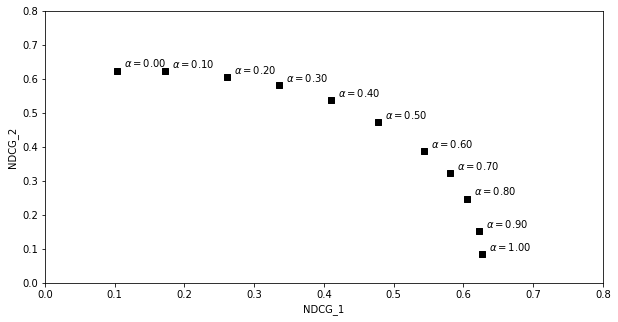

In [24]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlim([0.0, 0.8])
ax.set_ylim([0.0, 0.8])

handles = []

for alpha, ndcg_1, ndcg_2 in zip(alpha_values, ndcg_arr_1, ndcg_arr_2):
    h = plot_point(ndcg_1, ndcg_2, f"$\\alpha={alpha:.2f}$", "s", 0.01, 0.01)
handles.append(h)

ax.set_xlabel("NDCG_1");
ax.set_ylabel("NDCG_2");